# Kürzeste Pfade
(von einem gegebenen Knoten zu allen anderen Knoten)

## Tools für Experimente und Darstellung

Wir verwenden hier wieder `networkx` zur Repräsentation und zur Darstellung von Graphen.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from networkx.drawing.layout import circular_layout
import networkx as nx

Wir erstellen zufällig einen gerichteten Beispielgraphen. Zur besseren Darstellbarkeit verhindern wir die gleichzeitige Existenz von Kanten (u,v) und (v,u), dies ist für die Korrektheit der Algorithmen jedoch nicht erforderlich.

In [2]:
import random

def create_random_weighted_digraph(no_nodes, no_edges, min_edge_weight, max_edge_weight):
    graph = nx.DiGraph()
    graph.add_nodes_from(range(no_nodes))
    all_pairs = list((x,y) for x in range(no_nodes)
                           for y in range(x + 1, no_nodes))
    # print(all_pairs)
    possible_weights = list(range(min_edge_weight, max_edge_weight + 1))
    for n1, n2 in random.sample(all_pairs, no_edges):
        weight = random.choice(possible_weights)
        v, w = random.choice(((n1, n2), (n2, n1)))
        graph.add_edge(v, w, weight=weight)
    return graph
        
graph = create_random_weighted_digraph(8, 16, 0, 30)

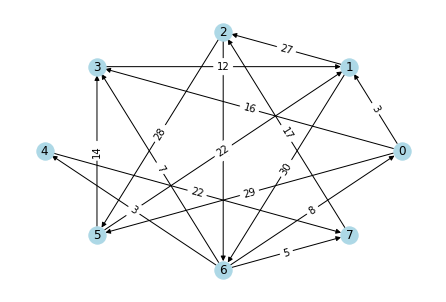

In [3]:
pos = circular_layout(graph)
edge_labels = dict([((u,v),d['weight']) for u,v,d in graph.edges(data=True)])
nx.draw(graph, pos, with_labels=True, node_size=300, node_color='lightblue')
_ = nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

 ## Dijkstras Algorithmus

Für Dijkstras Algorithmus benötigen wir eine indizierte Priority-Queue. Wir kopieren hierzu einfach die Implementierung von [Mehrgan Khoshpasand](https://mkhoshpa.github.io/IndexedPQ/) und erweitern sie noch um die Methoden `contains` und `entries`.

*Die Implementierungsdetails der indizierten Priority Queue sind kein Vorlesungsstoff*.

In [4]:
class IndexedMinPQ:
    def __init__(self,N):
        self.N = N
        self.key = [None for i in range(self.N)]
        self.pq = [None for i in range(self.N+1)]
        self.qp =[None for i in range(self.N)]
        self.total = 0

    def insert(self,i,key):
        assert type(i) is int
        if i >= self.N:
            raise IndexError('index is out of the range of IndexedMinPQ.')
        if self.key[i] is not None:
            raise IndexError('index is already in the IndexedMinPQ.')
        self.total += 1
        self.key[i] = key
        self.pq[self.total] = i
        self.qp[i] = self.total
        self.__swim(self.total)

    def __swim(self,i):
        parent_i = i//2

        while parent_i > 0 :
            key = self.key[self.pq[i]]
            parent_key = self.key[self.pq[parent_i]]
            if parent_key < key:
                break
            self.pq[i], self.pq[parent_i] = self.pq[parent_i], self.pq[i]
            self.qp[self.pq[i]] , self.qp[self.pq[parent_i]] = self.qp[self.pq[parent_i]],self.qp[self.pq[i]]
            i = parent_i
            parent_i = i // 2

    def deleteMin(self):
        if not self.isEmpty():
            out = self.pq[1]
            self.key[self.pq[1]] = None
            self.qp[self.pq[1]] = None
            self.pq[1] = self.pq[self.total]
            self.qp[self.pq[1]] = 1
            self.pq[self.total] = None
            self.total -= 1
            self.__sink(1)
            return out
        raise IndexError('IndexedMinPQ is Empty')

    def __sink(self,i):
        child_i = i * 2
        if child_i <= self.total:
            key = self.key[self.pq[i]]
            child_key = self.key[self.pq[child_i]]
            other_child = child_i + 1
            if other_child <= self.total:
                other_child_key =  self.key[self.pq[other_child]]
                if other_child_key < child_key:
                    child_i = other_child
                    child_key = other_child_key
            if child_key < key:
                self.pq[i], self.pq[child_i] = self.pq[child_i], self.pq[i]
                self.qp[self.pq[i]], self.qp[self.pq[child_i]] = self.qp[self.pq[child_i]], self.qp[self.pq[i]]
                self.__sink(child_i)

    def isEmpty(self):
        return self.total == 0

    def decreaseKey(self,i,key):
        if i<0 or i> self.N:
            raise IndexError('index i is not in the range')
        if self.key[i] is None:
            raise IndexError('index i is not in the IndexedMinPQ')
        assert type(i) is int
        assert key < self.key[i]
        self.key[i] = key
        self.__swim(self.qp[i])

    def increaseKey(self,i,key):
        if i<0 or i> self.N:
            raise IndexError('index i is not in the range')
        if self.key[i] is None:
            raise IndexError('index i is not in the IndexedMinPQ')
        assert type(i) is int
        assert key > self.key[i]
        self.key[i] = key
        self.__sink(self.qp[i])
        
    def contains(self,i):
        return self.key[i] is not None
    
    def entries(self):
        for x in self.pq[1:]:
            if x is None:
                break
            yield x

Wie bereits in früheren Fällen, verwenden wir im Notebook keine explizite Repräsentation der Kanten, sondern die API von networkx. Daher speichern wir auch kein Array `edge_to`, sondern merken uns stattdessen nur den Vorgängerknoten auf dem besten bekannten Pfad zu einem Knoten (wir bereits früher in einem Array `parent`). Da wir keine Multigraphen mit parallelen Kanten betrachten, gibt es jeweils nur eine Kante von `parent[i]` zu `i`und die Extraktion der kürzesten Pfade wird dadurch nicht komplizierter.

In [5]:
class DijkstraSSSP:
    def __init__(self, graph, start_node, node_positions):
        self.parent = [None] * len(graph)
        self.distance = [float('inf')] * len(graph)
        pq = IndexedMinPQ(len(graph))

        self.distance[start_node] = 0
        pq.insert(start_node, 0)
        while not pq.isEmpty():
            self.relax(graph, pq.deleteMin(), pq)
            self.dump(graph, node_positions, pq)

    def relax(self, graph, v, pq):
        print("Nach Relaxierung von Knoten %i:" % v)
        for w in graph.successors(v):
            edge_weight = \
                graph.get_edge_data(v,w)["weight"]
            if self.distance[v] + edge_weight < \
               self.distance[w]:
                self.parent[w] = v
                self.distance[w] = self.distance[v] + edge_weight
                if pq.contains(w):
                    pq.decreaseKey(w, self.distance[w])
                else:
                    pq.insert(w, self.distance[w])

    def path_to(self, node):
        if self.distance[node] == float('inf'):
            return None
        elif self.parent[node] is None:
            return [node]
        else:
            path = self.path_to(self.parent[node])
            path.append(node)
            return path
            
    def dump(self, graph, node_positions, queue):
        print("distances:", self.distance)
        print("parents:  ", self.parent)
        reached_nodes = set(x for x in range(len(graph)) if self.distance[x] != float('inf'))
        open_nodes = set(x for x in queue.entries())
        finished_nodes = reached_nodes - open_nodes
        finished_tree = [(self.parent[i],i) for i in finished_nodes if self.parent[i] is not None]
        open_edges = [(self.parent[i],i) for i in open_nodes if self.parent[i] is not None]

        nx.draw(graph, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color="gray")
        edge_labels=dict([((u,v,),d['weight']) for u,v,d in graph.edges(data=True)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        nx.draw_networkx_nodes(graph, pos, nodelist=finished_nodes, node_color='r')
        nx.draw_networkx_edges(graph, pos, edgelist=finished_tree, edge_color='r')

        nx.draw_networkx_nodes(graph, pos, nodelist=open_nodes, node_color='b')
        nx.draw_networkx_edges(graph, pos, edgelist=open_edges, edge_color='b')
        plt.show()

Nach Relaxierung von Knoten 0:
distances: [0, 3, inf, 16, inf, 29, inf, inf]
parents:   [None, 0, None, 0, None, 0, None, None]


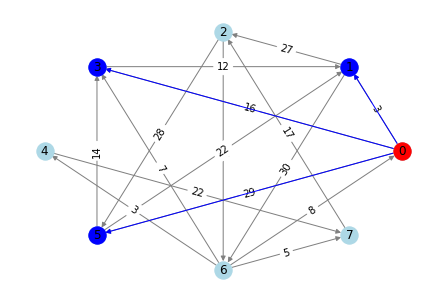

Nach Relaxierung von Knoten 1:
distances: [0, 3, 30, 16, inf, 29, 33, inf]
parents:   [None, 0, 1, 0, None, 0, 1, None]


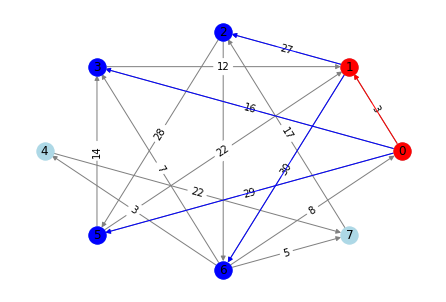

Nach Relaxierung von Knoten 3:
distances: [0, 3, 30, 16, inf, 29, 33, inf]
parents:   [None, 0, 1, 0, None, 0, 1, None]


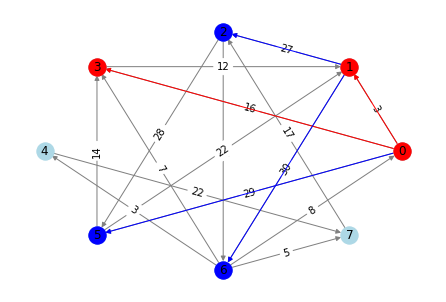

Nach Relaxierung von Knoten 5:
distances: [0, 3, 30, 16, inf, 29, 33, inf]
parents:   [None, 0, 1, 0, None, 0, 1, None]


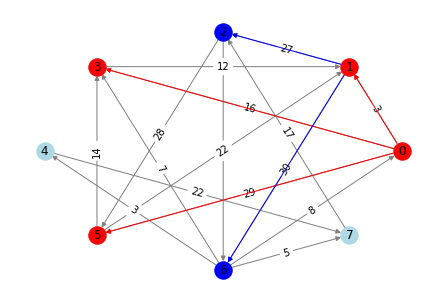

Nach Relaxierung von Knoten 2:
distances: [0, 3, 30, 16, inf, 29, 33, inf]
parents:   [None, 0, 1, 0, None, 0, 1, None]


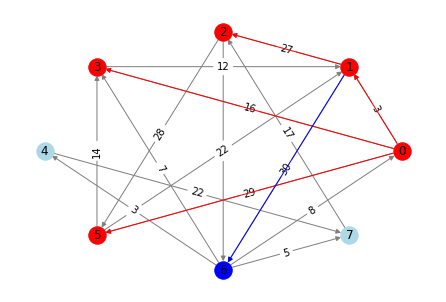

Nach Relaxierung von Knoten 6:
distances: [0, 3, 30, 16, 36, 29, 33, 38]
parents:   [None, 0, 1, 0, 6, 0, 1, 6]


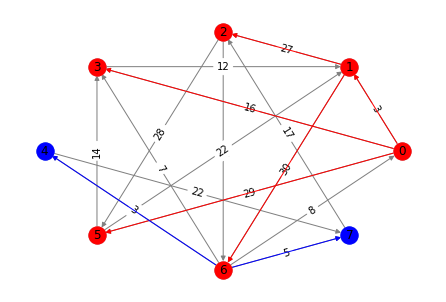

Nach Relaxierung von Knoten 4:
distances: [0, 3, 30, 16, 36, 29, 33, 38]
parents:   [None, 0, 1, 0, 6, 0, 1, 6]


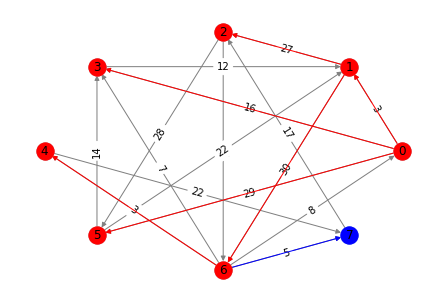

Nach Relaxierung von Knoten 7:
distances: [0, 3, 30, 16, 36, 29, 33, 38]
parents:   [None, 0, 1, 0, 6, 0, 1, 6]


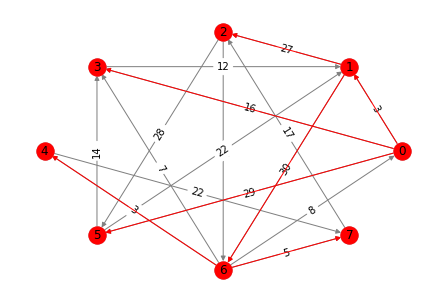

In [6]:
d = DijkstraSSSP(graph, 0, pos)

In [7]:
print(d.path_to(2))

[0, 1, 2]


 ## Azyklische Graphen

Wir erstellen zunächst einmal einen zufälligen azyklischen, gewichteten Graphen:

In [8]:
from networkx.generators.random_graphs import gnp_random_graph

def random_dag(number_nodes, min_weight, max_weight):
    random_graph = gnp_random_graph(number_nodes, 0.5, directed=True)
    # filter edges to get acyclic graph
    dag = nx.DiGraph((u,v,{'weight': random.randint(min_weight, max_weight)})
                     for u,v in random_graph.edges()
                     if u < v)
    # re-insert lost nodes
    for node in range(number_nodes):
        if node not in dag:
            dag.add_node(node)                           
    return dag
    
dag = random_dag(7, 0, 10)

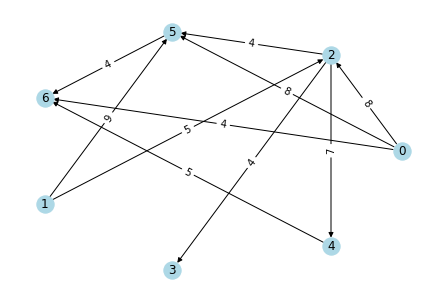

In [9]:
pos_dag = circular_layout(dag)
nx.draw(dag, pos_dag, with_labels=True, node_size=300, node_color='lightblue')
edge_labels_dag = dict([((u,v),d['weight']) for u,v,d in dag.edges(data=True)])
_ = nx.draw_networkx_edge_labels(dag, pos_dag, edge_labels=edge_labels_dag)

Für azyklische Graphen benötigen wir keine Priority-Queue, sondern können stattdessen eine topologische Sortierung als geeignete Relaxierungsreihenfolge der Knoten verwenden.

In [10]:
from networkx.algorithms.dag import topological_sort

class AcyclicSSSP:
    def __init__(self, graph, start_node, drawing_pos):
        self.parent = [None] * len(graph)
        self.distance = [float('inf')] * len(graph)
        
        processed_nodes = [] # only for drawing

        self.distance[start_node] = 0
        top_order = list(topological_sort(graph))
        print("Verwende folgende topologische Sortierung:", top_order, "\n")
        
        start_pos = top_order.index(start_node)
        for node in top_order[start_pos:]:
            self.relax(graph, node)
            processed_nodes.append(node)
            self.dump(graph, processed_nodes, drawing_pos)

    def relax(self, graph, v):
        print("Nach Relaxierung von Knoten %i:" % v)
        for w in graph.successors(v):
            edge_weight = graph.get_edge_data(v,w)["weight"]
            if self.distance[v] + edge_weight < self.distance[w]:
                self.parent[w] = v
                self.distance[w] = self.distance[v] + edge_weight

    def path_to(self, node):
        if self.distance[node] == float('inf'):
            return None
        elif self.parent[node] == None:
            return [node]
        else:
            path = self.path_to(self.parent[node])
            path.append(node)
            return path
            
    def dump(self, graph, processed_nodes, pos):
        print("distances:", self.distance)
        print("parents:  ", self.parent)
        
        nx.draw(graph, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color="gray")
        edge_labels=dict([((u,v,),d['weight']) for u,v,d in graph.edges(data=True)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        
        reached_nodes = set(x for x in range(len(graph))
                            if self.distance[x] != float('inf') and x not in processed_nodes)
        best_edges = [(self.parent[i],i) for i in reached_nodes
                      if i not in processed_nodes and self.parent[i] is not None]
        finished_edges = [(self.parent[i],i) for i in processed_nodes
                          if self.parent[i] is not None]
        
        nx.draw_networkx_nodes(graph, pos, nodelist=processed_nodes, node_color='r')
        nx.draw_networkx_edges(graph, pos, edgelist=finished_edges, edge_color='r')
        nx.draw_networkx_nodes(graph, pos, nodelist=reached_nodes, node_color='b')
        nx.draw_networkx_edges(graph, pos, edgelist=best_edges, edge_color='b')
        plt.show()

Verwende folgende topologische Sortierung: [0, 1, 2, 3, 4, 5, 6] 

Nach Relaxierung von Knoten 1:
distances: [inf, 0, 5, inf, inf, 9, inf]
parents:   [None, None, 1, None, None, 1, None]


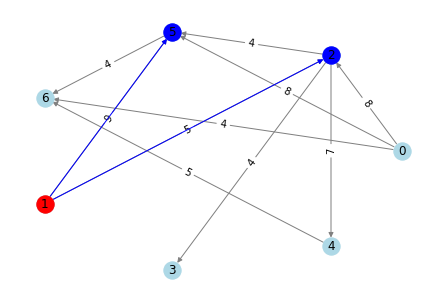

Nach Relaxierung von Knoten 2:
distances: [inf, 0, 5, 9, 12, 9, inf]
parents:   [None, None, 1, 2, 2, 1, None]


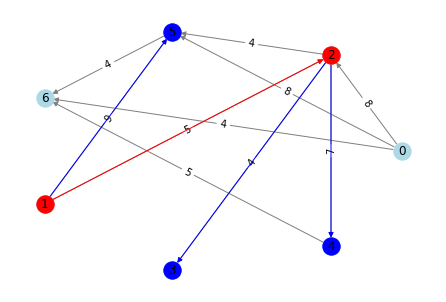

Nach Relaxierung von Knoten 3:
distances: [inf, 0, 5, 9, 12, 9, inf]
parents:   [None, None, 1, 2, 2, 1, None]


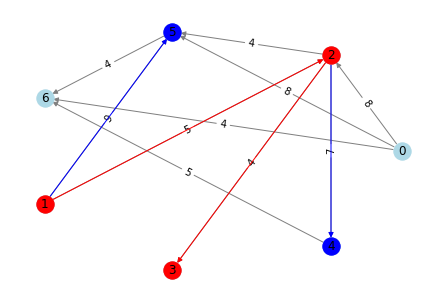

Nach Relaxierung von Knoten 4:
distances: [inf, 0, 5, 9, 12, 9, 17]
parents:   [None, None, 1, 2, 2, 1, 4]


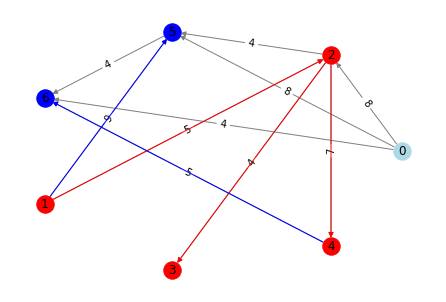

Nach Relaxierung von Knoten 5:
distances: [inf, 0, 5, 9, 12, 9, 13]
parents:   [None, None, 1, 2, 2, 1, 5]


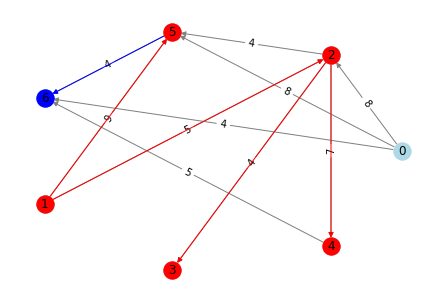

Nach Relaxierung von Knoten 6:
distances: [inf, 0, 5, 9, 12, 9, 13]
parents:   [None, None, 1, 2, 2, 1, 5]


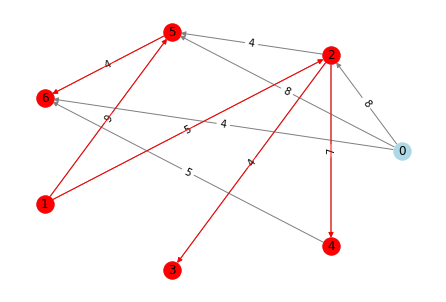

In [11]:
assp = AcyclicSSSP(dag, 1, pos_dag)

In [12]:
print(assp.path_to(5))

[1, 5]
